<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/main/IDP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrinsically disordered proteins in thermophilic bacteria

In this notebook we go through IDR prediction of various protein datasets and compare the IDR content of these datasets.

## Setup

[Biopython](https://biopython.org/) package is used to read .fasta files and work with sequences. Other packages are used to process the data, connect with API services to predict IDR, download results, etc.

In [1]:
# copy repo to get available datafiles

!git clone https://github.com/alibekk93/IDP_analysis.git

Cloning into 'IDP_analysis'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 143 (delta 5), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (143/143), 22.40 MiB | 27.87 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
# installation of Biopython
!pip install BIO

     |████████████████████████████████| 269 kB 6.8 MB/s 
     |████████████████████████████████| 2.3 MB 43.8 MB/s 


In [3]:
# Biopython
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat.MatrixInfo import blosum62

# connecting with API
import urllib.request
import json

# files uploading / dowmloading
from google.colab import files
import pickle

# other packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/Bio/SubsMat/__init__.py:131: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  BiopythonDeprecationWarning,


## Functions

In [4]:
def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.
  
  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

In [5]:
def calculate_iupred(proteinID_list: list, score_only: bool=True) -> list:
  """Calculate protein IDR profile using IUPred3 REST API

  Creates URL based on protein UniProt accession numbers
  (from a list). Each IDR profile is saved as a JSON file
  and put into a list. The JSON files are then unpacked,
  either all data or only IUPred3 score are saved.

  Parameters
  ----------
  proteinID_list : list
    a list of protein accessions for which to predict IDR
  score_only : bool (default=True)
    whether the return should only contain IUPRed3 score.
    Other data are AA sequence, and a binary disorder
    prediction.

  Returns
  -------
  list
    a list of either IUPred3 scores or of all data from
    each JSON as a dictionary.

  """

  # make a list of URLs
  iupredURL_list = ['http://iupred3.elte.hu/iupred3/' + proteinID + '.json' \
                    for proteinID in proteinID_list]

  # download JSON files
  print('Retrieving disorder values from server...')
  protein_files = [urllib.request.urlretrieve(iupredURL, proteinID  + '.json')\
                   for iupredURL, proteinID in zip(tqdm(iupredURL_list),\
                                                        proteinID_list)]
  
  # empty list for unpacked JSON data
  proteins = []
  
  # populate the empty list
  print('Unpacking json files...')
  for proteinID in tqdm(proteinID_list):
    with open('/content/{}.json'.format(proteinID), 'r') as f:
      d = json.load(f)
      # check if only scores need to be saved
      if score_only == True:
        d = d['iupred2']
      proteins.append(d)
  
  return proteins

In [6]:
def read_pickle_file(file_name: str):
  """A simple function to read pickle files

  Parameters
  ----------
  file_name : srt
    location of the pickle file
  
  Returns
  -------
  any format, but best with pd.DataFrames or lists
  
  """

  print(file_name + ' loading...')
  with open(file_name, 'rb') as f:
    result = pickle.load(f)
  print(file_name + ' loaded!')
  return result

In [7]:
def binary_disorder(disorder_list: list, threshold: float=0.5) -> list:
  """Returns a list of binary values for disordered
  residues given a threshold

  Parameters
  ----------
  disorder_list : list
    a list of disorder values
  threshold : float
    a binary threshold, 0.5 by default. Disorder score
    above the threshold means that the residue is
    considered to be disordered
  
  Returns
  -------
  list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  """

  return [1 if dis > threshold else 0 for dis in disorder_list]

In [8]:
def find_longest_binary_IDR(binary_disorder_list: list) -> int:
  """Finds the longest stretch of binary IDR for a
  given protein

  Parameters
  ----------
  binary_disorder_list : list
    a list of binary values indicating whether the
    residue is disordered (1) or not (0)
  
  Returns
  -------
  int
    a number of disordered residues in the longest
    IDR
  
  """

  # set max IDR length as zero
  max_IDR_len = 0

  # set current IDR length as zero
  current_IDR_len = 0
  # iterate though each residue
  for disorder in binary_disorder_list:
    if disorder == 1:
      # increase current IDR length if disordered
      current_IDR_len += 1
    else:
      # not part of IDR, save current length if max or continue
      if current_IDR_len > max_IDR_len:
        max_IDR_len = current_IDR_len
      current_IDR_len = 0

  return max_IDR_len

## Obtaining IUPred3 predictions for *E. coli* and *T. thermophilus* proteins

IUPred3 REST API works great for almost all proteins, however there are a couple exceptions.

First, IUPred3 only can predict IDR for proteins that are at least 20 AA long. For that reason we will filter out short proteins from our databases.

A more unfortunate issue is that in some rare cases the REST API does not return a JSON file due to server error 500. This happened with two protein accessions from our *E. coli* database (out of more than 4,000 accessions) - P76335 and P77650. The API still can provide results in text format, but those data cannot be downloaded as easily as JSON. To solve the issue, we obtain the results for the two accessions manually and concatenate the manual results with the automatic results in the same order as the data were in the original dataframe.

In [9]:
# read two .fasta files
EC_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/EscherichiaColiK12_allProteins.fasta')
TT_proteome_fasta = read_fasta('/content/IDP_analysis/datafiles/ThermusThermophilusHB8_allProteins.fasta')

# filter out short sequences (under 20 AA)
# short sequences do not get processed by IDR predictors
EC_proteome_fasta = EC_proteome_fasta[EC_proteome_fasta.Length > 19]
TT_proteome_fasta = TT_proteome_fasta[TT_proteome_fasta.Length > 19]

In [10]:
#@title # Which of TT files do you have already?

#@markdown These files take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

TT_proteome_filename = '/content/IDP_analysis/datafiles/TT_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell

TT_disorder_iupred3_filename = '' #@param {type: 'string'}

# working on TT files
if (TT_disorder_iupred3_filename == '') and (TT_proteome_filename == ''):
  print('TT data are not available, loading from API...')
  # calcuate disorder
  TT_disorder_iupred3 = calculate_iupred(TT_proteome.ID)
  # add disorder values to the dataframe
  TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
  # save the dataframe and the disorder list for future
  TT_proteome.to_pickle('TT_proteome.pkl')
  files.download('TT_proteome.pkl')
  with open('TT_disorder_iupred3.pkl', 'wb') as f:
    pickle.dump(TT_disorder_iupred3, f)
  files.download('TT_disorder_iupred3.pkl')
elif TT_proteome_filename == '':
  # load disorder values list
  TT_disorder_iupred3 = read_pickle_file(TT_disorder_iupred3_filename)
  # add disorder values to the dataframe
  TT_proteome['disorder_iupred3'] = TT_disorder_iupred3
  # save the dataframe for future
  TT_proteome.to_pickle('TT_proteome.pkl')
  files.download('TT_proteome.pkl')
else:
  # load the dataframe with disorder values
  TT_proteome = read_pickle_file(TT_proteome_filename)

/content/IDP_analysis/datafiles/TT_proteome.pkl loading...
/content/IDP_analysis/datafiles/TT_proteome.pkl loaded!


With *E. coli* the process is more complex because of 500 error on the server.

We have to save the data in parts, and two of these are manual.

In [11]:
from pandas.errors import EmptyDataError
#@title # Which of EC files do you have already?

#@markdown These files take a long time to be made,
#@markdown so it is better to upload them if you have
#@markdown them already.
#@markdown Please, input file names for those files
#@markdown that you already have. If you do not have
#@markdown a file, leave the string empty.

EC_proteome_filename = '/content/IDP_analysis/datafiles/EC_proteome.pkl' #@param {type: 'string'}

#@markdown If the file from above is available, there
#@markdown is no need to upload other files in this cell
#@markdown or do the manual input

EC_disorder_iupred3_filename = '' #@param {type: 'string'}
EC_disorder_iupred3_1_filename = 'EC_disorder_iupred3_1.pkl' #@param {type: 'string'}
EC_disorder_iupred3_2_filename = 'EC_disorder_iupred3_2.pkl' #@param {type: 'string'}
EC_disorder_iupred3_3_filename = 'EC_disorder_iupred3_3.pkl' #@param {type: 'string'}

#@markdown Use these links to manually get the data:
#@markdown [P76335](https://iupred3.elte.hu/iupred3/P76335),
#@markdown [P77650](https://iupred3.elte.hu/iupred3/P77650)

#@markdown Copy and paste all the output below:

EC_disorder_iupred3_P76335 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.0832\t? 2\tK\t0.0644\t? 3\tR\t0.0489\t? 4\tK\t0.0382\t? 5\tV\t0.0330\t? 6\tL\t0.0328\t? 7\tA\t0.0366\t? 8\tM\t0.0429\t? 9\tL\t0.0500\t? 10\tV\t0.0565\t? 11\tP\t0.0611\t? 12\tA\t0.0590\t? 13\tL\t0.0469\t? 14\tL\t0.0477\t? 15\tV\t0.0547\t? 16\tA\t0.0679\t? 17\tG\t0.0894\t? 18\tA\t0.1120\t? 19\tA\t0.1313\t? 20\tN\t0.1513\t? 21\tA\t0.1734\t? 22\tA\t0.1863\t? 23\tE\t0.1956\t? 24\tV\t0.1966\t? 25\tY\t0.1941\t? 26\tN\t0.1948\t? 27\tK\t0.1950\t0 28\tD\t0.1883\t0 29\tG\t0.1796\t0 30\tN\t0.1633\t0 31\tK\t0.1362\t0 32\tL\t0.1187\t0 33\tD\t0.1035\t0 34\tL\t0.0984\t0 35\tY\t0.0961\t0 36\tG\t0.1031\t0 37\tK\t0.1061\t0 38\tV\t0.1117\t0 39\tV\t0.1248\t0 40\tG\t0.1329\t0 41\tL\t0.1496\t0 42\tH\t0.1528\t0 43\tY\t0.1620\t0 44\tF\t0.1740\t0 45\tS\t0.1923\t0 46\tD\t0.2007\t0 47\tD\t0.1953\t0 48\tS\t0.1785\t0 49\tG\t0.1715\t0 50\tS\t0.1805\t0 51\tD\t0.2025\t0 52\tG\t0.2295\t0 53\tD\t0.2611\t0 54\tM\t0.3026\t0 55\tS\t0.3309\t0 56\tY\t0.3543\t0 57\tA\t0.3642\t0 58\tR\t0.3538\t0 59\tI\t0.3315\t0 60\tG\t0.2807\t0 61\tF\t0.2450\t0 62\tK\t0.2060\t0 63\tG\t0.1945\t0 64\tE\t0.1879\t0 65\tT\t0.1832\t0 66\tQ\t0.1739\t0 67\tI\t0.1770\t0 68\tA\t0.1878\t0 69\tD\t0.2029\t0 70\tQ\t0.2060\t0 71\tF\t0.2075\t0 72\tT\t0.2074\t0 73\tG\t0.2137\t0 74\tY\t0.2241\t0 75\tG\t0.2351\t0 76\tQ\t0.2586\t0 77\tW\t0.2819\t0 78\tE\t0.2930\t0 79\tF\t0.3281\t0 80\tN\t0.3520\t0 81\tI\t0.3981\t0 82\tG\t0.4303\t0 83\tA\t0.4563\t0 84\tN\t0.4690\t0 85\tG\t0.4713\t0 86\tP\t0.4702\t0 87\tE\t0.4715\t0 88\tS\t0.4615\t0 89\tD\t0.4413\t0 90\tK\t0.4215\t0 91\tG\t0.4050\t0 92\tN\t0.3914\t0 93\tT\t0.3769\t0 94\tA\t0.3755\t0 95\tT\t0.3662\t0 96\tR\t0.3457\t0 97\tL\t0.3199\t0 98\tA\t0.2829\t0 99\tF\t0.2582\t0 100\tA\t0.2278\t0 101\tG\t0.2008\t0 102\tL\t0.1745\t0 103\tG\t0.1426\t0 104\tF\t0.1259\t0 105\tG\t0.1124\t0 106\tQ\t0.1046\t0 107\tN\t0.1025\t0 108\tG\t0.1049\t0 109\tT\t0.1021\t0 110\tF\t0.1106\t0 111\tD\t0.1218\t0 112\tY\t0.1412\t0 113\tG\t0.1482\t0 114\tR\t0.1590\t0 115\tN\t0.1557\t0 116\tY\t0.1507\t0 117\tG\t0.1429\t0 118\tV\t0.1330\t0 119\tV\t0.1259\t0 120\tY\t0.1266\t0 121\tD\t0.1269\t0 122\tV\t0.1391\t0 123\tE\t0.1410\t0 124\tA\t0.1443\t0 125\tW\t0.1492\t0 126\tT\t0.1642\t0 127\tD\t0.1804\t0 128\tM\t0.1907\t0 129\tL\t0.2025\t0 130\tP\t0.2243\t0 131\tE\t0.2361\t0 132\tF\t0.2445\t0 133\tG\t0.2523\t0 134\tG\t0.2716\t0 135\tD\t0.2782\t0 136\tT\t0.2868\t0 137\tY\t0.2953\t0 138\tA\t0.3092\t0 139\tG\t0.3261\t0 140\tA\t0.3343\t0 141\tD\t0.3288\t0 142\tN\t0.3234\t0 143\tF\t0.3114\t0 144\tM\t0.3078\t0 145\tN\t0.3138\t0 146\tG\t0.3088\t0 147\tR\t0.2939\t0 148\tA\t0.2858\t0 149\tN\t0.2792\t0 150\tG\t0.2649\t0 151\tV\t0.2526\t0 152\tA\t0.2519\t0 153\tT\t0.2427\t0 154\tY\t0.2357\t0 155\tR\t0.2314\t0 156\tN\t0.2288\t0 157\tN\t0.2260\t0 158\tG\t0.2187\t0 159\tF\t0.2006\t0 160\tF\t0.1626\t0 161\tG\t0.0927\t0' #@param {type: 'string'}
EC_disorder_iupred3_P77650 = '# IUPred3 - improved prediction of protein disorder with a focus on specific user applications  # G\xE1bor Erd\u0151s, M\xE1ty\xE1s Pajkos, Zsuzsanna Doszt\xE1nyi # Nucleic Acids Research 2021, Submitted # IUPred2A: context-dependent prediction of protein disorder as a function of redox state and protein binding # Balint Meszaros, Gabor Erdos, Zsuzsanna Dosztanyi # Nucleic Acids Research 2018;46(W1):W329-W337. # IUPred2 type: long # POS\tAMINO ACID\tIUPRED SCORE\tEXP DIS 1\tM\t0.1753\t? 2\tK\t0.2426\t? 3\tE\t0.2756\t? 4\tK\t0.2882\t? 5\tT\t0.2902\t? 6\tI\t0.2881\t? 7\tI\t0.2854\t? 8\tI\t0.2835\t? 9\tV\t0.2820\t? 10\tG\t0.2800\t? 11\tG\t0.2703\t? 12\tG\t0.2513\t? 13\tQ\t0.2393\t? 14\tA\t0.2352\t? 15\tA\t0.2440\t? 16\tA\t0.2729\t? 17\tM\t0.3107\t? 18\tA\t0.3464\t? 19\tA\t0.3714\t? 20\tA\t0.3820\t? 21\tS\t0.3685\t? 22\tL\t0.3522\t? 23\tR\t0.3216\t? 24\tQ\t0.2998\t? 25\tQ\t0.2742\t? 26\tG\t0.2561\t? 27\tF\t0.2583\t? 28\tT\t0.2687\t? 29\tG\t0.2976\t? 30\tE\t0.3133\t? 31\tL\t0.3280\t? 32\tH\t0.3296\t? 33\tL\t0.3303\t? 34\tF\t0.3368\t? 35\tS\t0.3577\t? 36\tD\t0.3801\t? 37\tE\t0.3871\t? 38\tR\t0.3853\t? 39\tH\t0.3718\t? 40\tL\t0.3606\t? 41\tP\t0.3543\t? 42\tY\t0.3731\t? 43\tE\t0.3809\t? 44\tR\t0.4000\t? 45\tP\t0.4227\t? 46\tP\t0.4379\t? 47\tL\t0.4620\t? 48\tS\t0.4704\t? 49\tK\t0.4791\t? 50\tS\t0.4789\t? 51\tM\t0.4690\t? 52\tL\t0.4452\t? 53\tL\t0.4285\t? 54\tE\t0.4082\t? 55\tD\t0.3812\t? 56\tS\t0.3425\t? 57\tP\t0.3091\t? 58\tQ\t0.2822\t? 59\tL\t0.2733\t? 60\tQ\t0.2799\t? 61\tQ\t0.2950\t? 62\tV\t0.3126\t? 63\tL\t0.3365\t? 64\tP\t0.3579\t? 65\tA\t0.3601\t? 66\tN\t0.3379\t? 67\tW\t0.3160\t? 68\tW\t0.2908\t? 69\tQ\t0.2711\t? 70\tE\t0.2526\t? 71\tN\t0.2339\t? 72\tN\t0.2177\t? 73\tV\t0.2216\t? 74\tH\t0.2312\t? 75\tL\t0.2703\t? 76\tH\t0.3107\t? 77\tS\t0.3462\t? 78\tG\t0.3643\t? 79\tV\t0.3765\t? 80\tT\t0.3608\t? 81\tI\t0.3558\t? 82\tK\t0.3441\t? 83\tT\t0.3360\t? 84\tL\t0.3198\t? 85\tG\t0.3035\t? 86\tR\t0.3009\t? 87\tD\t0.3162\t? 88\tT\t0.3438\t? 89\tR\t0.3643\t? 90\tE\t0.3650\t? 91\tL\t0.3497\t? 92\tV\t0.3216\t? 93\tL\t0.3007\t? 94\tT\t0.2743\t? 95\tN\t0.2511\t? 96\tG\t0.2085\t? 97\tE\t0.1710\t? 98\tS\t0.1334\t? 99\tW\t0.1212\t? 100\tH\t0.1226\t? 101\tW\t0.1522\t? 102\tD\t0.1740\t? 103\tQ\t0.1928\t? 104\tL\t0.2025\t? 105\tF\t0.1966\t? 106\tI\t0.1870\t? 107\tA\t0.1717\t? 108\tT\t0.1563\t? 109\tG\t0.1295\t? 110\tA\t0.1087\t? 111\tA\t0.1053\t? 112\tA\t0.1177\t? 113\tR\t0.1426\t? 114\tP\t0.1587\t? 115\tL\t0.1735\t? 116\tP\t0.1765\t? 117\tL\t0.1853\t? 118\tL\t0.1885\t? 119\tD\t0.2018\t? 120\tA\t0.2095\t? 121\tL\t0.2095\t? 122\tG\t0.2044\t? 123\tE\t0.2080\t? 124\tR\t0.2106\t? 125\tC\t0.2114\t? 126\tF\t0.2163\t? 127\tT\t0.2160\t? 128\tL\t0.2155\t? 129\tR\t0.2112\t? 130\tH\t0.2171\t? 131\tA\t0.2307\t? 132\tG\t0.2564\t? 133\tD\t0.2812\t? 134\tA\t0.3009\t? 135\tA\t0.3196\t? 136\tR\t0.3176\t? 137\tL\t0.3234\t? 138\tR\t0.3175\t? 139\tE\t0.2972\t? 140\tV\t0.2634\t? 141\tL\t0.2368\t? 142\tQ\t0.2124\t? 143\tP\t0.1916\t? 144\tE\t0.1702\t? 145\tR\t0.1590\t? 146\tS\t0.1519\t? 147\tV\t0.1419\t? 148\tV\t0.1363\t? 149\tI\t0.1281\t? 150\tI\t0.1298\t? 151\tG\t0.1318\t? 152\tA\t0.1362\t? 153\tG\t0.1284\t? 154\tT\t0.1187\t? 155\tI\t0.1224\t? 156\tG\t0.1250\t? 157\tL\t0.1441\t? 158\tE\t0.1523\t? 159\tL\t0.1656\t? 160\tA\t0.1727\t? 161\tA\t0.1835\t? 162\tS\t0.1826\t? 163\tA\t0.1745\t? 164\tT\t0.1611\t? 165\tQ\t0.1451\t? 166\tR\t0.1327\t? 167\tR\t0.1266\t? 168\tC\t0.1325\t? 169\tK\t0.1411\t? 170\tV\t0.1682\t? 171\tT\t0.1825\t? 172\tV\t0.1953\t? 173\tI\t0.2086\t? 174\tE\t0.2259\t? 175\tL\t0.2573\t? 176\tA\t0.2758\t? 177\tA\t0.2960\t? 178\tT\t0.2967\t? 179\tV\t0.2948\t? 180\tM\t0.2840\t? 181\tG\t0.2798\t? 182\tR\t0.2730\t? 183\tN\t0.2746\t? 184\tA\t0.2851\t? 185\tP\t0.3088\t? 186\tP\t0.3459\t? 187\tP\t0.3853\t? 188\tV\t0.4296\t? 189\tQ\t0.4526\t? 190\tR\t0.4537\t? 191\tY\t0.4289\t? 192\tL\t0.3898\t? 193\tL\t0.3432\t? 194\tQ\t0.2833\t? 195\tR\t0.2328\t? 196\tH\t0.1788\t? 197\tQ\t0.1353\t? 198\tQ\t0.1027\t? 199\tA\t0.0920\t? 200\tG\t0.0987\t? 201\tV\t0.1177\t? 202\tR\t0.1408\t? 203\tI\t0.1632\t? 204\tL\t0.1851\t? 205\tL\t0.2048\t? 206\tN\t0.2122\t? 207\tN\t0.2038\t? 208\tA\t0.1799\t? 209\tI\t0.1493\t? 210\tE\t0.1349\t? 211\tH\t0.1368\t? 212\tV\t0.1499\t? 213\tV\t0.1761\t? 214\tD\t0.2141\t? 215\tG\t0.2603\t? 216\tE\t0.3001\t? 217\tK\t0.3367\t? 218\tV\t0.3630\t? 219\tE\t0.3759\t? 220\tL\t0.3741\t? 221\tT\t0.3540\t? 222\tL\t0.3246\t? 223\tQ\t0.2900\t? 224\tS\t0.2570\t? 225\tG\t0.2175\t? 226\tE\t0.1667\t? 227\tT\t0.1216\t? 228\tL\t0.1015\t? 229\tQ\t0.1007\t? 230\tA\t0.1085\t? 231\tD\t0.1155\t? 232\tV\t0.1270\t? 233\tV\t0.1379\t? 234\tI\t0.1441\t? 235\tY\t0.1473\t? 236\tG\t0.1408\t? 237\tI\t0.1308\t? 238\tG\t0.1072\t? 239\tI\t0.0962\t? 240\tS\t0.0963\t? 241\tA\t0.1218\t? 242\tN\t0.1584\t? 243\tE\t0.1912\t? 244\tQ\t0.2142\t? 245\tL\t0.2450\t? 246\tA\t0.2783\t? 247\tR\t0.3087\t? 248\tE\t0.3335\t? 249\tA\t0.3398\t? 250\tN\t0.3244\t? 251\tL\t0.3028\t? 252\tD\t0.2852\t? 253\tT\t0.2811\t? 254\tA\t0.2837\t? 255\tN\t0.2837\t? 256\tG\t0.2711\t? 257\tI\t0.2537\t? 258\tV\t0.2327\t? 259\tI\t0.2269\t? 260\tD\t0.2189\t? 261\tE\t0.2048\t? 262\tA\t0.1694\t? 263\tC\t0.1438\t? 264\tR\t0.1294\t? 265\tT\t0.1271\t? 266\tC\t0.1290\t? 267\tD\t0.1309\t? 268\tP\t0.1407\t? 269\tA\t0.1451\t? 270\tI\t0.1458\t? 271\tF\t0.1642\t? 272\tA\t0.1836\t? 273\tG\t0.1958\t? 274\tG\t0.2028\t? 275\tD\t0.1942\t? 276\tV\t0.1820\t? 277\tA\t0.1752\t? 278\tI\t0.1826\t? 279\tT\t0.1909\t? 280\tR\t0.1914\t? 281\tL\t0.1971\t? 282\tD\t0.2084\t? 283\tN\t0.2398\t? 284\tG\t0.2642\t? 285\tA\t0.2878\t? 286\tL\t0.3212\t? 287\tH\t0.3455\t? 288\tR\t0.3590\t? 289\tC\t0.3732\t? 290\tE\t0.3789\t? 291\tS\t0.3847\t? 292\tW\t0.3705\t? 293\tE\t0.3513\t? 294\tN\t0.3221\t? 295\tA\t0.2889\t? 296\tN\t0.2728\t? 297\tN\t0.2639\t? 298\tQ\t0.2570\t? 299\tA\t0.2393\t? 300\tQ\t0.2207\t? 301\tI\t0.2187\t? 302\tA\t0.2146\t? 303\tA\t0.2124\t? 304\tA\t0.2044\t? 305\tA\t0.1882\t? 306\tM\t0.1720\t? 307\tL\t0.1548\t? 308\tG\t0.1342\t? 309\tL\t0.1226\t? 310\tP\t0.1021\t? 311\tL\t0.0932\t? 312\tP\t0.0844\t? 313\tL\t0.0877\t? 314\tL\t0.1041\t? 315\tP\t0.1301\t? 316\tP\t0.1528\t? 317\tP\t0.1536\t? 318\tW\t0.1476\t0 319\tF\t0.1425\t0 320\tW\t0.1421\t0 321\tS\t0.1482\t0 322\tD\t0.1525\t0 323\tQ\t0.1529\t0 324\tY\t0.1578\t0 325\tS\t0.1667\t0 326\tD\t0.1825\t0 327\tN\t0.1858\t0 328\tL\t0.1808\t0 329\tQ\t0.1706\t0 330\tF\t0.1620\t0 331\tI\t0.1579\t0 332\tG\t0.1611\t0 333\tD\t0.1788\t0 334\tM\t0.2020\t0 335\tR\t0.2315\t0 336\tG\t0.2634\t0 337\tD\t0.2980\t0 338\tD\t0.3269\t0 339\tW\t0.3438\t0 340\tL\t0.3431\t0 341\tC\t0.3339\t0 342\tR\t0.3155\t0 343\tG\t0.2963\t0 344\tN\t0.2740\t0 345\tP\t0.2410\t0 346\tE\t0.2130\t0 347\tT\t0.1912\t0 348\tQ\t0.1876\t0 349\tK\t0.1845\t0 350\tA\t0.1864\t0 351\tI\t0.1850\t0 352\tW\t0.1734\t0 353\tF\t0.1602\t0 354\tN\t0.1432\t0 355\tL\t0.1309\t0 356\tQ\t0.1038\t0 357\tN\t0.0838\t0 358\tG\t0.0619\t0 359\tV\t0.0506\t0 360\tL\t0.0588\t0 361\tI\t0.0920\t0 362\tG\t0.1259\t0 363\tA\t0.1534\t0 364\tV\t0.1682\t0 365\tT\t0.1704\t0 366\tL\t0.1666\t0 367\tN\t0.1639\t0 368\tQ\t0.1649\t0 369\tG\t0.1640\t0 370\tR\t0.1642\t0 371\tE\t0.1765\t0 372\tI\t0.2079\t0 373\tR\t0.2530\t0 374\tP\t0.2881\t0 375\tI\t0.3143\t0 376\tR\t0.3080\t0 377\tK\t0.2851\t0 378\tW\t0.2480\t0 379\tI\t0.2154\t0 380\tQ\t0.1891\t0 381\tS\t0.1632\t0 382\tG\t0.1348\t0 383\tK\t0.1156\t0 384\tT\t0.1021\t0 385\tF\t0.1026\t0 386\tD\t0.1136\t0 387\tA\t0.1214\t0 388\tK\t0.1147\t0 389\tL\t0.1033\t0 390\tL\t0.0903\t0 391\tI\t0.0829\t0 392\tD\t0.0779\t0 393\tE\t0.0716\t0 394\tN\t0.0632\t0 395\tI\t0.0523\t0 396\tA\t0.0397\t0 397\tL\t0.0274\t0 398\tK\t0.0190\t0 399\tS\t0.0197\t0 400\tL\t0.0374\t0' #@param {type: 'string'}

# working on EC files
if (EC_disorder_iupred3_filename == '') and (EC_proteome_filename == ''):
  print('Looking at partial files...')
  # check that manual input was given
  if EC_disorder_iupred3_P76335 == '' or EC_disorder_iupred3_P77650 == '':
    print('Please provide the namual input!')
    raise EmptyDataError()
  # calcuate disorder in three separate runs unless available as pickle
  dis_fns = [EC_disorder_iupred3_1_filename, EC_disorder_iupred3_2_filename, EC_disorder_iupred3_3_filename]
  for i in range(3):
    if dis_fns[i] == '':
      print(dis_fns[i] + ' not available, loading from API...')
      if i == 0:
        EC_disorder_iupred3_1 = calculate_iupred(EC_proteome.ID.iloc[:2700])
        # save the disorder values
        with open('EC_disorder_iupred3_1.pkl', 'wb') as f:
          pickle.dump(EC_disorder_iupred3_1, f)
        files.download('EC_disorder_iupred3_1.pkl')
      elif i == 1:
        EC_disorder_iupred3_2 = calculate_iupred(EC_proteome.ID.iloc[2701:3882])
        # save the disorder values
        with open('EC_disorder_iupred3_2.pkl', 'wb') as f:
          pickle.dump(EC_disorder_iupred3_2, f)
        files.download('EC_disorder_iupred3_2.pkl')
      elif i == 2:
        EC_disorder_iupred3_3 = calculate_iupred(EC_proteome.ID.iloc[3883:])
        # save the disorder values
        with open('EC_disorder_iupred3_3.pkl', 'wb') as f:
          pickle.dump(EC_disorder_iupred3_3, f)
        files.download('EC_disorder_iupred3_3.pkl')
    else:
      print(dis_fns[i] + ' available, loading...')
      if i == 0:
        EC_disorder_iupred3_1 = read_pickle_file(dis_fns[i])
      elif i == 1:
        EC_disorder_iupred3_2 = read_pickle_file(dis_fns[i])
      elif i == 2:
        EC_disorder_iupred3_3 = read_pickle_file(dis_fns[i])
  # processing manual output strings
  EC_disorder_iupred3_P76335 = [float(EC_disorder_iupred3_P76335.split('\t')[i])\
        for i in range(5, len(EC_disorder_iupred3_P76335.split('\t')), 3)]
  EC_disorder_iupred3_P77650 = [float(EC_disorder_iupred3_P77650.split('\t')[i])\
        for i in range(5, len(EC_disorder_iupred3_P77650.split('\t')), 3)]
  print('Manual data loaded')
  # merging the lists together
  EC_disorder_iupred3 = [*EC_disorder_iupred3_1, EC_disorder_iupred3_P76335,
                         *EC_disorder_iupred3_2, EC_disorder_iupred3_P77650,
                         *EC_disorder_iupred3_3]
  # add disorder values to the dataframe
  EC_proteome['disorder_iupred3'] = EC_disorder_iupred3
  # save the dataframe and the disorder list for future
  EC_proteome.to_pickle('EC_proteome.pkl')
  files.download('EC_proteome.pkl')
  # save the disorder values
  with open('EC_disorder_iupred3.pkl', 'wb') as f:
    pickle.dump(EC_disorder_iupred3, f)
  files.download('EC_disorder_iupred3.pkl')
elif EC_proteome_filename == '':
  # load disorder values list
  EC_disorder_iupred3 = read_pickle_file(EC_disorder_iupred3_filename)
  # add disorder values to the dataframe
  EC_proteome['disorder_iupred3'] = EC_disorder_iupred3
  # save the dataframe for future
  EC_proteome.to_pickle('EC_proteome.pkl')
  files.download('EC_proteome.pkl')
else:
  # load the dataframe with disorder values
  EC_proteome = read_pickle_file(EC_proteome_filename)

/content/IDP_analysis/datafiles/EC_proteome.pkl loading...
/content/IDP_analysis/datafiles/EC_proteome.pkl loaded!


In [12]:
TT_proteome['disorder_iupred3_binary'] = TT_proteome.disorder_iupred3.apply(binary_disorder, threshold=0.5)
EC_proteome['disorder_iupred3_binary'] = EC_proteome.disorder_iupred3.apply(binary_disorder, threshold=0.5)

TT_proteome['disorder_iupred3_mean'] = TT_proteome.disorder_iupred3.apply(np.mean)
EC_proteome['disorder_iupred3_mean'] = EC_proteome.disorder_iupred3.apply(np.mean)

TT_proteome['disorder_iupred3_binary_mean'] = TT_proteome.disorder_iupred3_binary.apply(np.mean)
EC_proteome['disorder_iupred3_binary_mean'] = EC_proteome.disorder_iupred3_binary.apply(np.mean)

TT_proteome['longest_IDR_iupred3'] = TT_proteome.disorder_iupred3_binary.apply(find_longest_binary_IDR)
EC_proteome['longest_IDR_iupred3'] = EC_proteome.disorder_iupred3_binary.apply(find_longest_binary_IDR)

{'boxes': [<matplotlib.lines.Line2D at 0x7f96cf36a310>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96cf371310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96cf379350>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96cf371dd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96cf36a850>,
  <matplotlib.lines.Line2D at 0x7f96cf36ad90>]}

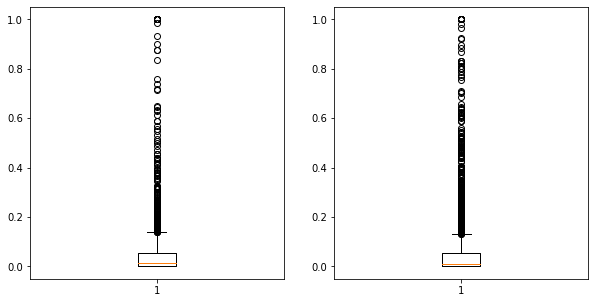

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].boxplot(TT_proteome.disorder_iupred3_binary_mean)
axs[1].boxplot(EC_proteome.disorder_iupred3_binary_mean)

{'boxes': [<matplotlib.lines.Line2D at 0x7f96cee2c2d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96cee302d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96cee39310>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96cee30d90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96cee2c810>,
  <matplotlib.lines.Line2D at 0x7f96cee2cd50>]}

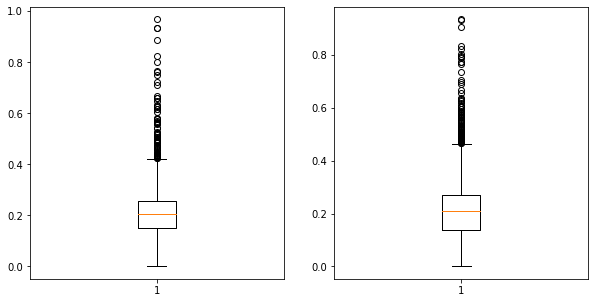

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].boxplot(TT_proteome.disorder_iupred3_mean)
axs[1].boxplot(EC_proteome.disorder_iupred3_mean)

{'boxes': [<matplotlib.lines.Line2D at 0x7f96ced0a710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96ced13710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96ced1c750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96ced1c210>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96ced0ac50>,
  <matplotlib.lines.Line2D at 0x7f96ced131d0>]}

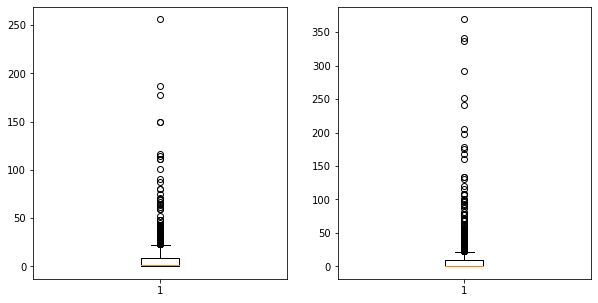

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].boxplot(TT_proteome.longest_IDR_iupred3)
axs[1].boxplot(EC_proteome.longest_IDR_iupred3)

{'boxes': [<matplotlib.lines.Line2D at 0x7f96ced86390>],
 'caps': [<matplotlib.lines.Line2D at 0x7f96cf379fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f96ced92ed0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f96ced92a50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f96cedf29d0>,
  <matplotlib.lines.Line2D at 0x7f96cedf2910>]}

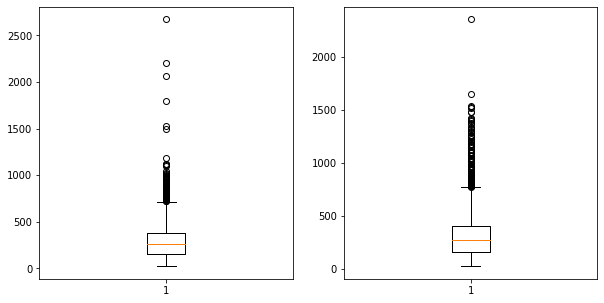

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].boxplot(TT_proteome.Length)
axs[1].boxplot(EC_proteome.Length)

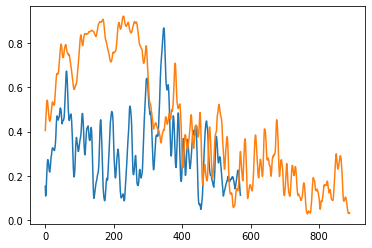

In [ ]:
plt.plot(TT_proteome[TT_proteome.ID=='P48515'].disorder_iupred3.iloc[0])
plt.plot(EC_proteome[EC_proteome.ID=='P0A705'].disorder_iupred3.iloc[0])

In [ ]:
seq1 = TT_proteome[TT_proteome.ID=='P48515'].Sequence.iloc[0]
seq2 = EC_proteome[EC_proteome.ID=='P0A705'].Sequence.iloc[0]

alignment = pairwise2.align.localds(seq1, seq2, blosum62, -1, -0.5)
print(format_alignment(*alignment[0]))

  2 AK--VR-----------I---YQL--A----KE--LGMETQEL-L-ELLDQM---G--V--AY-K-SHA-STLEEK--DAE-AVRELVKEQRG----LQ-E-KLAEE----ER-----RKSLPRRPPVVVIMGHVDHGKTTLLDYLRKS-RIAEK-EAGGITQHVGAFEVKTPQ-GTVV-FIDTPGHEAFTTIRQRGAKVA-DIAVIVIAADDGIMPQTE-EAIAHAKAAGAK--LIFAINKIDL-PQADPEKVKRQLMER-GFV-PEEYGGDA-IVIP-ISAKTGQGVQD-LLEMILLL-AE-LEDYRADPNAEPR-----G-VILESK-LDK-QAGI-IANMLVQEGTF-RVGDYVV-AG-EAYGRIRAMMDAD-GNQRK--EAGPGSA-VQVLGFQEL---PHA-GD-V-VEWVP-DLEA-AKEIAEE--R--K-EER-K-AREEEEKARRPRTMAE-LLRA-MQEEGRK--ELNLILRADTQGSLEAIQH-ILARE-STED-VKINILLAQ-VGAP-TESDVLLAQTA-NAAILA-FGVNPPGSVKK--KAEEKGVL-LKTF-RIIYDLVDEVRN--MVKGQR-EPQYKEEVLGQ-AEVRA-IFRL-PT-GKQVAGCMVTQGRI-PR-NAEVRVLRDGQV-IWQGRIASLKRFKEDVREVAQ-GYECGIGLDGFDDFREGDVIEAFQMVEVP---A
    |.  ||           .   .|   |    ..  .| ||  . . ||...|   |  |  |. | . | .|...   |.| |  .||.|..|    |. | .| ||    .|     ..  | |.|||.||||||||||.||||.| | ..| . ||||||||.||..|.| . | .. |.|||||.|||..|.|||. | ||.|.|.|||||.||||  |||.||||  |.  ...|.||||  |.|||..||..| .. | . |||.||.. .|   .|||.|.|. |

In [ ]:
seq1_disorder_full = TT_proteome[TT_proteome.ID=='P48515'].disorder_iupred3.iloc[0].copy()
seq2_disorder_full = EC_proteome[EC_proteome.ID=='P0A705'].disorder_iupred3.iloc[0].copy()

In [ ]:
for i, residue in enumerate(alignment[0].seqA):
  if residue == '-':
    try:
      seq1_disorder_full.insert(i, seq1_disorder_full[i-1])
    except: seq1_disorder_full.insert(i, np.nan)

In [ ]:
for i, residue in enumerate(alignment[0].seqB):
  if residue == '-':
    try:
      seq2_disorder_full.insert(i, seq2_disorder_full[i-1])
    except: seq2_disorder_full.insert(i, np.nan)

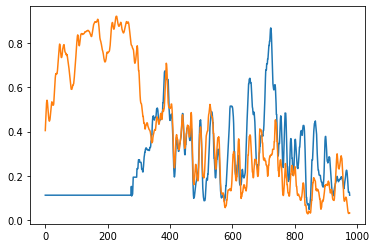

In [ ]:
plt.plot(seq1_disorder_full)
plt.plot(seq2_disorder_full)

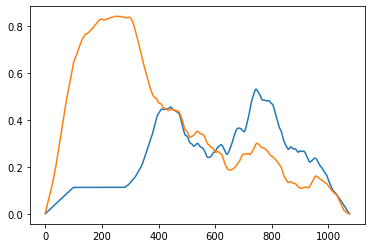

In [ ]:
plt.plot(np.convolve(seq1_disorder_full, np.ones(100)/100))
plt.plot(np.convolve(seq2_disorder_full, np.ones(100)/100))

In [13]:
BLAST_results = pd.read_csv('/content/BLAST_results.csv')

In [18]:
BLAST_results.head()

,EC,TT,%Match,MatchLen,NumMisMat,GapOpen,QueryStart,QueryEnd,DB_SeqStart,DB_SeqEnd,E-Val,BitScore
0,P0AB74,Q5SHF7,49.54,109,55,0,75,183,73,181,7.000000e-32,130.0
1,P0AB74,Q5SHF7,36.49,74,47,0,210,283,231,304,8.000000e-14,70.6
2,P0AB74,Q5SHF7,54.17,48,22,0,9,56,8,55,2.000000e-10,59.6
3,P0AB74,Q5SHF7,64.71,34,12,0,187,220,187,220,2.000000e-07,49.4
4,P0A796,P21777,49.54,109,55,0,115,223,115,223,2.000000e-34,139.0


In [30]:
test = EC_proteome[(EC_proteome.disorder_iupred3_binary_mean > 0.7) &
            (EC_proteome.Length > 100)].merge(BLAST_results, left_on='ID', right_on='EC')

In [49]:
test

,ID,Sequence,Length,disorder_iupred3,disorder_iupred3_binary,disorder_iupred3_mean,disorder_iupred3_binary_mean,longest_IDR_iupred3,EC,TT,%Match,MatchLen,NumMisMat,GapOpen,QueryStart,QueryEnd,DB_SeqStart,DB_SeqEnd,E-Val,BitScore
0,Q6BEX5,MKRFPLFLLFTLLTLSTVPAQADIIDDTIGNIQQAINDAYNPDRGR...,109,"[0.07420806396921197, 0.05662195908744172, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.522194,0.798165,0,Q6BEX5,Q5SKE0,37.14,35,22,0,63,97,204,238,0.004000,33.4
1,Q6BEX5,MKRFPLFLLFTLLTLSTVPAQADIIDDTIGNIQQAINDAYNPDRGR...,109,"[0.07420806396921197, 0.05662195908744172, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.522194,0.798165,0,Q6BEX5,Q5SKE0,33.33,39,26,0,66,104,200,238,0.007000,32.4
2,Q6BEX5,MKRFPLFLLFTLLTLSTVPAQADIIDDTIGNIQQAINDAYNPDRGR...,109,"[0.07420806396921197, 0.05662195908744172, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.522194,0.798165,0,Q6BEX5,Q5SHV6,27.59,58,42,0,49,106,79,136,0.007000,32.4
3,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,"[0.37856981911794896, 0.4447437246376811, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.623515,0.702929,131,P02929,Q5SHS2,33.33,69,46,0,63,131,40,108,0.000007,43.9
4,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,"[0.37856981911794896, 0.4447437246376811, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.623515,0.702929,131,P02929,Q5SK26,38.64,44,27,0,57,100,346,389,0.002000,35.8
5,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,"[0.37856981911794896, 0.4447437246376811, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.623515,0.702929,131,P02929,Q5SLK5,37.50,32,20,0,63,94,150,181,0.005000,34.5
6,P02929,MTLDLPRRFPWPTLLSVCIHGAVVAGLLYTSVHQVIELPAPAQPIS...,239,"[0.37856981911794896, 0.4447437246376811, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.623515,0.702929,131,P02929,Q5SJG1,31.71,41,28,0,57,97,29,69,0.009000,33.6
7,P29131,MAQRDYVRRSQPAPSRRKKSTSRKKQRNLPAVSPAMVAIAAAVLVT...,319,"[0.6097724044102351, 0.6546117381596284, 0.690...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.697314,0.830721,198,P29131,Q5SHS2,27.59,58,42,0,248,305,114,171,0.010000,33.9


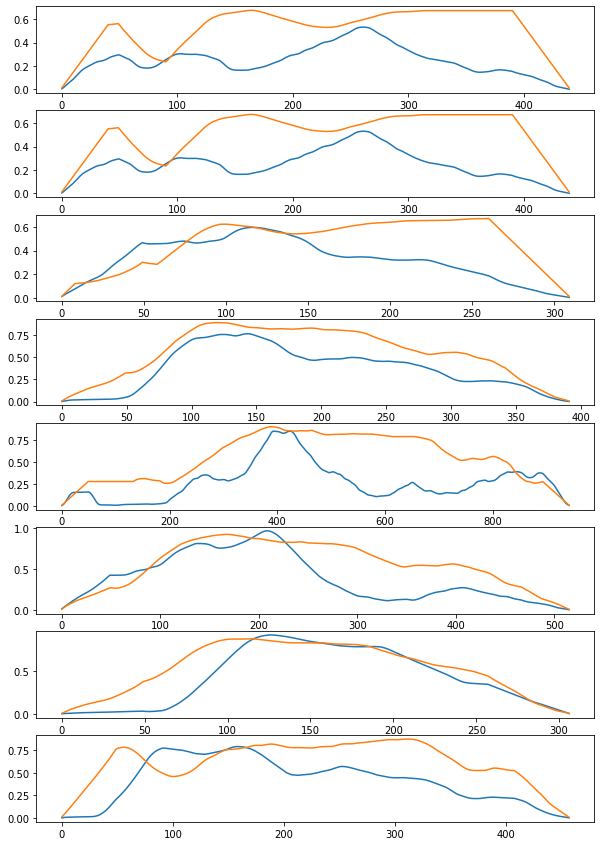

In [48]:
n_data = len(test)

fig, axs = plt.subplots(n_data, 1, figsize=(10,15))
for i in range(n_data):
  TT = test.TT.iloc[i]
  EC = test.EC.iloc[i]

  seq1 = TT_proteome[TT_proteome.ID==TT].Sequence.iloc[0]
  seq2 = EC_proteome[EC_proteome.ID==EC].Sequence.iloc[0]

  seq1_disorder_full = TT_proteome[TT_proteome.ID==TT].disorder_iupred3.iloc[0].copy()
  seq2_disorder_full = EC_proteome[EC_proteome.ID==EC].disorder_iupred3.iloc[0].copy()

  alignment = pairwise2.align.localds(seq1, seq2, blosum62, -1, -0.5)
  # print(format_alignment(*alignment[0]))

  for j, residue in enumerate(alignment[0].seqA):
    if residue == '-':
      try:
        seq1_disorder_full.insert(j, seq1_disorder_full[j-1])
      except: seq1_disorder_full.insert(j, np.nan)
  
  for k, residue in enumerate(alignment[0].seqB):
    if residue == '-':
      try:
        seq2_disorder_full.insert(k, seq2_disorder_full[k-1])
      except: seq2_disorder_full.insert(k, np.nan)
  
  # axs[i].plot(seq1_disorder_full)
  # axs[i].plot(seq2_disorder_full)

  axs[i].plot(np.convolve(seq1_disorder_full, np.ones(50)/50))
  axs[i].plot(np.convolve(seq2_disorder_full, np.ones(50)/50))

In [ ]:
TT_proteome[TT_proteome.ID=='Q5SIN6'].Sequence.iloc[0]

'MRVLEVQGVTKRFGGLVAVNQVSLEVNEGGDLLRHRSERGGQDHLLQPPHGDLHPGRGPDPLPRPGHHGLHPRQGGQARHRAHLPEHPPLRGHDRPGEHPGGAAHPHPRPLPARPPPHPPRPKGGEKGPGGGLEPLGVRGPPAPQGRARPQPPLRRAEEAGDRPRPRPQAQAPPPGRARRGHEPQGDGGPAGVHPENPQRDGAHHPPH'

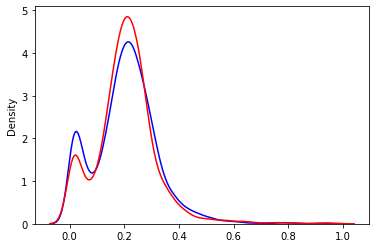

In [ ]:
sns.kdeplot([np.mean(dis) for dis in EC_proteome.disorder_iupred3], color='blue')
sns.kdeplot([np.mean(dis) for dis in TT_proteome.disorder_iupred3], color='red')